In [1]:
%matplotlib widget
import numpy as np
import json, glob
import os, math
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
from datetime import datetime

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.timing_tool import *
from alvra_tools.utils import *
from alvra_tools.YAG_scans import *
from ipyfilechooser import FileChooser

import warnings
warnings.filterwarnings('ignore')

### Choose the json file:

In [2]:
fc = FileChooser('/sf/alvra/data/p19637/raw')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p19637/raw', filename='', title='HTML(value='', layout=Layout(display='none')…

In [16]:
quantile_band = 0.5

Delay_mm,Delay_fs,Pump_probe,\
Pump_probe_all,Pump_probe_std,Pump_probe_std_err, Pump_probe_avg = YAG_scan_noTT(fc.selected,quantile_band)

pp = Pump_probe[:,0]
err_pp_low = Pump_probe[:,1]
err_pp_high = Pump_probe[:,2]

Processing: run0160-YAG_scan_pink
Step 41 of 41: Processing acq0041

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet       251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH0:VAL_GET 251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH2:VAL_GET 251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 251 / 251 -> 0% loss
complete channels: 3 / 3 -> 0% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Laser rep rate is 50.0 Hz (delayed or dark)
Pump scheme is 1:1
Loaded 125 pump and 125 unpump shots
Quantile range = 0.25 0.75
Loaded 41 files, size of the arrays = 41
Shape of pump probe data is (41, 125)


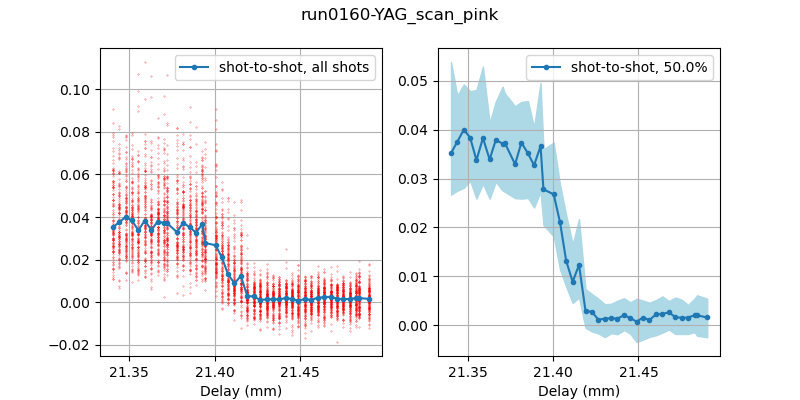

In [17]:
plt.figure(figsize = (8,4))
plt.suptitle(fc.selected.split('/')[-3])

plt.subplot(121)
for i in range(len(Delay_mm)):
    xe = Delay_mm[i]
    ye = Pump_probe_all[i,:]
    plt.plot([xe] * len(ye), ye, 'r.', ms=.5, alpha=0.8)
plt.plot(Delay_mm, pp, label='shot-to-shot, all shots', marker='.')
plt.xlabel("Delay (mm)")
plt.legend(loc="best")
#plt.ylim(-0.04, 0.08)
plt.grid()

plt.subplot(122)
plt.plot(Delay_mm, pp, label='shot-to-shot, {}%'.format(quantile_band*100), marker='.')
plt.fill_between(np.squeeze(Delay_mm), err_pp_low, err_pp_high, color='lightblue')
plt.xlabel("Delay (mm)")
plt.legend(loc="best")
plt.grid()

plt.show()

## Choose fit function

In [18]:
# err function ---------------> [x0, amplitude, width, offset]
# exp_gauss_heaviside --------> [x0, amplitude, width, offset, lifetime]
# conv_exp_gauss_heaviside2 --> [x0, amplitude, width, offset, lifetime, a, b]

fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
#fit = Fit(conv_exp_gauss_heaviside, estimate_conv_exp_gauss_heaviside_parameters) 
#fit = Fit(conv_exp_gauss_heaviside2, estimate_conv_exp_gauss_heaviside2_parameters)

## Do the fit

In [19]:
fit.estimate(Delay_mm, pp)            # this sets some internal params 
#fit.p0 = better_p0(fit.p0, 0, 210.42) # overwrite some values (index) if needed: 
#fit.p0 = better_p0(fit.p0, 4, 250) # overwrite some values (index) if needed: 

fit.fit(Delay_mm,pp)                  # calculate the fit
pp_fit = fit.eval(Delay_mm)           # evaluate the curve for plotting

t0_mm = fit.popt[0]
width_mm = fit.popt[2]
width_fs = mm2fs(width_mm,0)

print("Position t0 =",np.round(t0_mm,5),"mm")
#print("Width =",np.abs(np.round(width_mm,3))*1000,"um")
#print("Position t0 =",np.round(t0_fs,5),"fs")
print("Width =",np.abs(np.round(width_fs,5)),"fs")

Position t0 = 21.40498 mm
Width = 162.86272 fs


## Plot

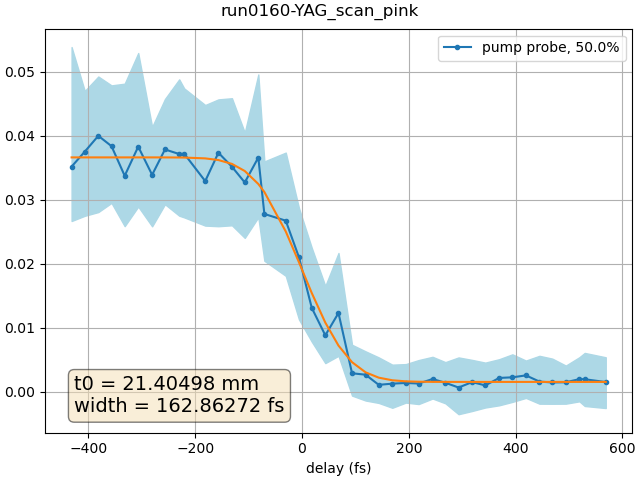

Returned t0 from fit = 21.40498278980891 mm 
Offset to guessed t0 = 21.415129756142537 mm => -67.69327288166056 fs


In [20]:
Delay_fs = mm2fs(Delay_mm,t0_mm)

fig, ax = plt.subplots(constrained_layout=True)
#fig, ax = plt.subplots()
plt.suptitle(fc.selected.split('/')[-3])

plt.plot(Delay_fs, pp, label='pump probe, {}%'.format(quantile_band*100),marker='.')
plt.fill_between(Delay_fs, err_pp_low, err_pp_high, color='lightblue')

plt.plot(Delay_fs, pp_fit)

plt.grid()
plt.xlabel("delay (fs)")
plt.legend(loc="best")


boxstyle = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
boxtext = '\n'.join((r't0 = {} mm'.format(np.round(t0_mm, 5)),
                     #r'Deltat0 = {} fs'.format(np.round(t0_fs, 5)),
                   r'width = {} fs'.format(np.abs(np.round(width_fs, decimals = 5)))))
plt.text(0.05, 0.05, boxtext, transform=ax.transAxes, bbox=boxstyle, fontsize=14)

plt.show()
print ('Returned t0 from fit = {} mm '.format(t0_mm))
print ('Offset to guessed t0 = {} mm => {} fs'.format(fit.p0[0], mm2fs(t0_mm, fit.p0[0])))

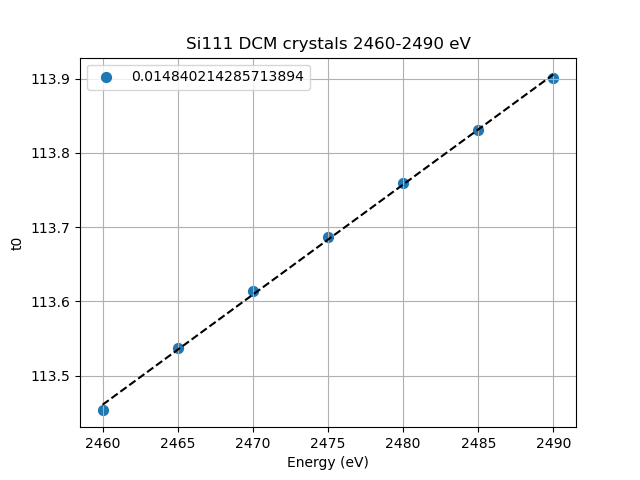

slope (mm/eV) = 0.014840214285713894


In [98]:
energy=np.array([2460,2465,2470,2475,2480,2485,2490])
t0= np.array([113.4531,113.5376,113.6135, 113.6870, 113.7598, 113.8305, 113.90161])

#t0_fs= np.array([(t0-113.4531)*2/(3335.64)])
#print(t0_fs)
#plt.figure(figsize = (8,4))
#plt.plot(energy, t0_fs, label='Mono Calibration 2460-2490 eV',marker='o')
#plt.show



m,b = np.polyfit(energy,t0, 1) 

plt.figure()
plt.title('Si111 DCM crystals 2460-2490 eV')

plt.plot (energy, m*energy + b,  '--', color='black')
plt.scatter(energy, t0, s = 200, marker='.',label = str(m))
plt.legend(loc='best')
plt.xlabel('Energy (eV)')
plt.ylabel('t0')
plt.grid()
plt.show()

print('slope (mm/eV) = {}'.format(m))

# Loop over several runs

In [170]:
datafiles = []
for file in glob('/sf/alvra/data/p19262/raw/scan_info/*_YAG_scan_Si111*'):
    datafiles.append(file)
datafiles = sorted(datafiles, key = os.path.getmtime)
patch = datafiles
patch.remove('/sf/alvra/data/p19262/raw/scan_info/022_YAG_scan_Si111_3020.json')
patch

/sf/alvra/anaconda/alvra-analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['/sf/alvra/data/p19262/raw/scan_info/021_YAG_scan_Si111_3030.json',
 '/sf/alvra/data/p19262/raw/scan_info/023_YAG_scan_Si111_3020.json',
 '/sf/alvra/data/p19262/raw/scan_info/024_YAG_scan_Si111_3010.json',
 '/sf/alvra/data/p19262/raw/scan_info/025_YAG_scan_Si111_3000.json',
 '/sf/alvra/data/p19262/raw/scan_info/026_YAG_scan_Si111_2990.json']

In [171]:
quantile_band = 0.5

Timezero_start = 18.12529816007258 

########################################################################
from sfdata import SFScanInfo

t0_fs_scan =[]
width_fs_scan = []

for json_file in patch:
    print (json_file)
    scan = SFScanInfo(json_file)
    
    Delay_mm,Delay_fs,Pump_probe,_,_,_,_ = YAG_scan_noTT(json_file,quantile_band)
        
    pp = Pump_probe[:,0]
    
    fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
    # fit = Fit(conv_exp_gauss_heaviside, estimate_conv_exp_gauss_heaviside_parameters) 
    # fit = Fit(conv_exp_gauss_heaviside2, estimate_conv_exp_gauss_heaviside2_parameters)
    
    fit.estimate(Delay_mm, pp)      # this sets some internal params 
           
    #fit.p0 = better_p0(fit.p0, 0, Timezero_start)  # overwrite some values if needed

    fit.fit(Delay_mm,pp)            # calculate the fit
    pp_fit = fit.eval(Delay_mm)     # evaluate the curve for plotting
    
    t0_mm = fit.popt[0]
    width_mm = fit.popt[2]    
    
    t0_fs_scan.append(mm2fs(t0_mm,Timezero_start))
    width_fs_scan.append(mm2fs(width_mm,0))


Processing: 026_YAG_scan_Si111_2990.json
Step 41 of 41: Processing run_001193

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet       503 / 503 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH0:VAL_GET 503 / 503 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH2:VAL_GET 503 / 503 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 503 / 503 -> 0% loss
complete channels: 3 / 3 -> 0% incomplete

--------------------------------------------------------------------------------

Pump rep rate (FEL) is 50.0 Hz
Probe rep rate (laser) is 100.0 Hz
Quantile range = 0.25 0.75
Loaded 41 files, size of the arrays = 41
Shape of pump probe data is (41, 250)


In [172]:
Energy_eV = np.array([3030, 3020, 3010, 3000, 2990])

<IPython.core.display.Javascript object>


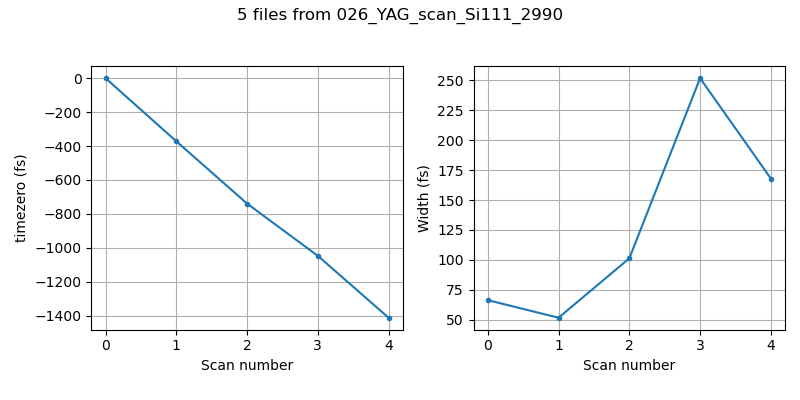

In [173]:
plt.figure(figsize = (8,4))
plt.suptitle ('{} files from {}'.format(len(patch), json_file.split('/')[-1].split('.')[0]))

plt.subplot(121)
plt.plot(t0_fs_scan, marker='.')
plt.xlabel('Scan number')
plt.ylabel('timezero (fs)')
plt.grid()

plt.subplot(122)
plt.plot(width_fs_scan, marker='.')
plt.xlabel("Scan number")
plt.ylabel('Width (fs)')
plt.grid()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

<IPython.core.display.Javascript object>


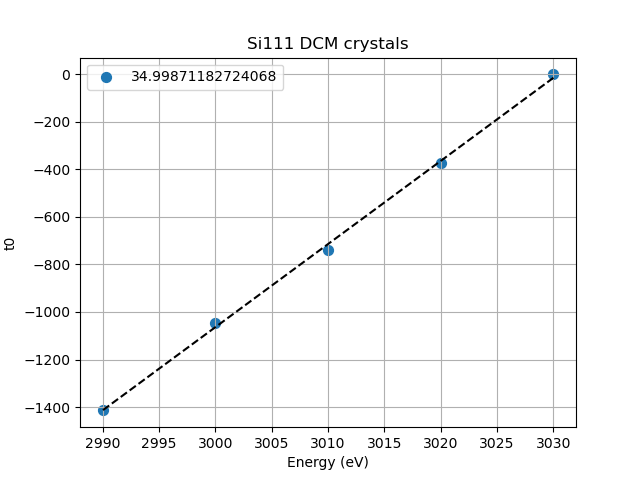

slope (fs/eV) = 34.99871182724068


In [174]:
m,b = np.polyfit(Energy_eV,t0_fs_scan, 1) 

plt.figure()
plt.title('Si111 DCM crystals')

plt.plot (Energy_eV, m*Energy_eV + b,  '--', color='black')
plt.scatter(Energy_eV, t0_fs_scan, s = 200, marker='.',label = str(m))
plt.legend(loc='best')
plt.xlabel('Energy (eV)')
plt.ylabel('t0')
plt.grid()
plt.show()

print('slope (fs/eV) = {}'.format(m))

In [96]:
print (b)

-61984.81282805531


/sf/alvra/anaconda/alvra-analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
quantile_laser = 0.68

Timezero_loop = 189.8264819165063

channel_pressure = 'SLAAR11-LTIM01-EVR0:DUMMY_PV8_NBS'

channel_list_pp = [channel_Events, channel_LaserDiode, channel_Laser_refDiode, channel_pressure]
channel_list_all = channel_list_pp + [channel_delay_harm]

########################################################################
from sfdata import SFScanInfo

width_fs_loop = []
t0_fs_loop =[]
timestamp = []
scan_number = []

skipped_runs = []
Pressure_scan = []

for json_file in patch:
    print (json_file)
    scan_number.append(json_file.split('/')[-1].split('_')[-1].split('.')[0])
    scan = SFScanInfo(json_file)
    Delay_fs = scan.readbacks - Timezero_loop *2/(299792458*1e3*1e-15)
    Delay_mm = scan.readbacks /2*(299792458*1e3*1e-15)
    
    Pump_probe_all = []
    Pump_probe = []
    Pump_probe_avg =[]
    Pump_probe_std = []
    Pump_probe_std_err = []
    Pressure_run = []
    
    with h5py.File(scan.files[0][1], 'r') as fn:
        timestamp.append(fn[channel_Events]['timestamp'][()])
    
    for i, step in enumerate(scan):
        check_files_and_data(step)
        clear_output(wait=True)
        print ('Step {} of {}: Processing {}'.format(i+1, len(scan.files), scan.files[i]))
        
        
        try:
            resultsPP, results_FEL, pids_pump, pids_unpump = load_data_compact_FEL_pump(channel_list_pp, channel_list_all, step)

            Laser_pump = resultsPP[channel_LaserDiode].pump
            Laser_ref_pump = resultsPP[channel_Laser_refDiode].pump
            Laser_unpump = resultsPP[channel_LaserDiode].unpump
            Laser_ref_unpump = resultsPP[channel_Laser_refDiode].unpump
            
            Pressure_run.append(np.mean(resultsPP[channel_pressure].pump))

            #Izero_FEL = results_FEL[channel_Izero117]

            #Laser_diff = -np.log10((Laser_pump/Laser_ref_pump) / (Laser_unpump/ Laser_ref_unpump)) #/ (Izero_FEL)
            Laser_diff = -np.log10((Laser_pump) / (Laser_unpump))
            #Laser_diff = ((Laser_pump) / (Laser_unpump))

            Pump_probe_all.append(Laser_diff)
            df_pump_probe = pd.DataFrame(Laser_diff)
            Pump_probe.append(np.nanquantile(df_pump_probe, [0.5, 0.5 - quantile_laser/2, 0.5 + quantile_laser/2]))

            Pump_probe_std.append(np.nanmean(Laser_diff))
            Pump_probe_std_err.append(np.nanstd(Laser_diff))#/np.sqrt(len(Laser_diff)))

            Pump = np.median(Laser_pump)
            Unpump = np.median(Laser_unpump)
            Pump_probe_avg.append(-np.log10((Pump) / (Unpump)))  
        except:
            Delay_mm = np.delete(Delay_mm, i)
            Delay_fs = np.delete(Delay_fs, i)
            skipped_runs.append(scan.files[i])
    
    Pressure_scan.append(np.mean(Pressure_run))
    
    Pump_probe_all = np.asarray(Pump_probe_all)
    Pump_probe = np.asarray(Pump_probe)
    Pump_probe_avg = np.asarray(Pump_probe_avg)
    Pump_probe_std = np.asarray(Pump_probe_std)
    Pump_probe_std_err = np.asarray(Pump_probe_std_err)
    
    minlen = min(len(i) for i in Pump_probe_all)
    def cut(arr, minlen):
        return np.array([i[:minlen] for i in arr])
    Pump_probe_all = cut(Pump_probe_all, minlen)


    Delay_mm = np.asarray(Delay_mm)
    Delay_fs = np.asarray(Delay_fs)
    
    pp_loop = Pump_probe[:,0]
    Delay_fs_toFit_loop = np.copy(Delay_fs)#(Delay_mm - Timezero_loop)*2/(3e8*1e3*1e-15) 
    
    index = ~(np.isnan(Delay_fs_toFit_loop) | np.isnan(pp_loop))
#     parameters_fs_loop,extras = curve_fit(conv_exp_gauss_heaviside, Delay_fs_toFit_loop, pp_loop, p0 = [0, 0.02, 100, 0, 700])
    parameters_fs_loop,extras = curve_fit(errfunc_fwhm, Delay_fs_toFit_loop, pp_loop, p0 = [0, 0.08, 200, 0])
    #exp_gauss_heaviside:  x0, amplitude, fwhm, offset, lifetime
    t0_fs_loop.append(parameters_fs_loop[0])
    width_fs_loop.append(np.abs(parameters_fs_loop[2]))
    
scan_number = np.asarray(scan_number)    

In [4]:
offset_space = 71.3     # this is in um

offset_time = 2*(offset_space * 1e-6)/3e8/1e-15            #factor of 2 because of the delay stage, results in fs
print ("An offset of",offset_space,"um corresponds to an offset of",np.round(offset_time,4),"fs")

An offset of 71.3 um corresponds to an offset of 475.3333 fs


/das/work/p19/p19300/anaconda/alvra-analysis-p19300/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
offset_time = 163      # this is in fs

offset_space = 3e8 * (offset_time * 1e-15)/2/1e-6          #factor of 2 because of the delay stage, results in um
print ("An offset of",offset_time,"fs corresponds to an offset of",np.round(offset_space,4),"um")